In [206]:
import os
os.chdir('C:\\Users\\Vinim\\Documents\\github\\tcc_vinicius')

## 1. Encontrar a correlação entre (algum aspecto do) sentimento das notícias e o retorno do mercado 

### modelo de dados ações

* definir 3 ações para serem trabalhadas

In [208]:
import pandas as pd
from data_processing.y_finance import Stocks
from datetime import date
import matplotlib.pyplot as plt

In [209]:
ambev = Stocks('ABEV3')
petro = Stocks('PETR4')
vale = Stocks('VALE3')

In [210]:
start_date = '2024-01-10'
end_date = date.today () # '2024-03-12' 


ambev.get_price_historic(start_date=start_date,
                         end_date=end_date)
petro.get_price_historic(start_date=start_date,
                         end_date=end_date)
vale.get_price_historic(start_date=start_date,
                         end_date=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


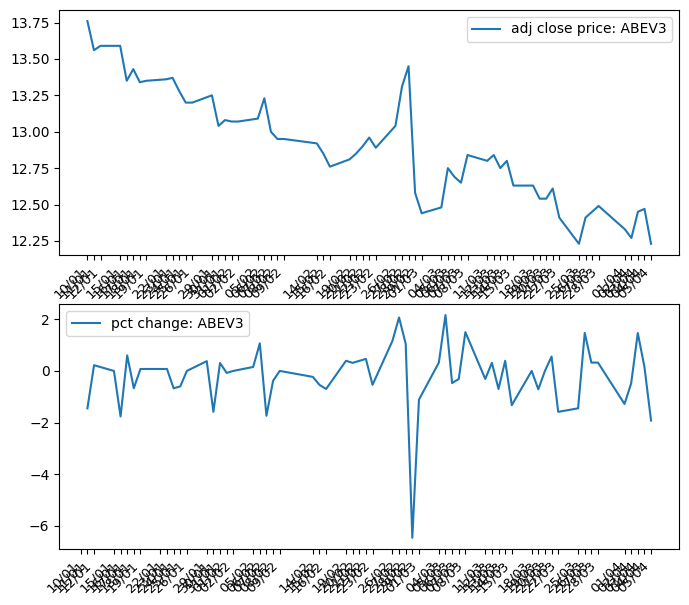

In [236]:
fig, axes = plt.subplots(2,1,figsize= (8,7))
company = ambev

company.plot_price(axes[0])
company.plot_pct_change(axes[1])
axes[0].legend()
axes[1].legend()

plt.show()

* calcular se o modelo é estacionario

In [237]:
import autoregressive_model as arm

In [238]:
def valdiacao_estacionariedade(data):
    # Teste de Dickey-Fuller Aumentado (ADF)
    adf_result = arm.teste_estacionariedade(data, 'adf')
    print('\n-----------------------------')

    # Teste KPSS
    kpss_result = arm.teste_estacionariedade(data, 'kpss')
    print('\n-----------------------------')

In [239]:
data = company.price['price_variation'][1:]
# data = company.price['adj close']

valdiacao_estacionariedade(data)

O valor-p do teste ADF é: 0.0
A série parece ser estacionária com base no teste ADF.
A estatistica de teste é -6.844411223293088

-----------------------------
O valor-p do teste KPSS é: 0.1
A série parece ser não estacionária com base no teste KPSS.
A estatistica de teste é 0.1707674255545958

-----------------------------


C:\Users\Vinim\Documents\github\tcc_vinicius\autoregressive_model.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = teste(series)


### modelo de dados sentimentos

In [240]:
# df = pd.read_csv("planilhas//df_sample_march_full_2.csv", index_col=0)
df['datePublished'] = pd.to_datetime(df['datePublished'])
df['datePublished'] = df['datePublished'].dt.date

# retirar dados que contenha IBOVESPA
filtro_ibovespa  = df['name'].str.upper().str.contains('IBOVESPA')
# df.loc[filtro_ibovespa, ['name','full_text', 'key', 'relevance']].sample(2).values
df.loc[filtro_ibovespa, 'relevance'] = 0

# filtragem de notícias classificadas de forma adequada
df = df[df['relevance'] == 1].copy()

# remoção dos valores de sentimentos que não foi retornado como número
df['sentiment score'] = pd.to_numeric(df['sentiment score'], errors='coerce')
df = df[df['sentiment score'].notna()].copy()

# positivo
df.loc[df['sentiment score'] > 0, 'sentiment score positive'] = df.loc[df['sentiment score'] > 0, 'sentiment score']
df['sentiment score positive'].fillna(0,inplace=True)

# negativo
df.loc[df['sentiment score'] < 0, 'sentiment score negative'] = df.loc[df['sentiment score'] < 0, 'sentiment score']
df['sentiment score negative'].fillna(0,inplace=True)

In [242]:
convercao= {'petro':   'Company: Petrobras | Ticket: PETR4',
            'vale':    'Company: Vale | Ticket: VALE3',
            'itau':    'Company: Itaú Unibanco | Ticket: ITUB4',
            'ambev':   'Company: Ambev | Ticket: ABEV3',
            'weg':     'Ticket: WEGE3 - company name: WEG',
            'bradesco':'Company: Banco Bradesco | Ticket: BBDC4',
            'banco do brasil':'Company: Banco do Brasil | Ticket: BBAS3',
            'btg':     'Company: Banco BTG Pactual | Ticket: BPAC11',
            'santander':'Company: Banco Santander | Ticket: SANB3',
            'itausa':  'Company: Itaúsa | Ticket: ITSA4'}

In [253]:
company_name = 'ambev'

def sentiment_company(df, company_name):
    df_company = df[df['key_standard'] == convercao[company_name]].reset_index(drop=True).copy()

    grouped = df_company.groupby(['datePublished','key_standard']).agg({'sentiment score':['count', 'mean', 'sum','median', 'max', 'min'],
                                                                'sentiment score positive': 'sum',
                                                                'sentiment score negative': 'sum' })
    grouped.reset_index(inplace=True)
    grouped.columns = grouped.columns.droplevel(0)

    columnas_name = ['datePublished', 'key_standard', 'sentiment score_count',
                    'sentiment score_mean', 'sentiment score_sum', 'sentiment score_median', 
                    'sentiment score_max', 'sentiment score_min', 
                    'score positive_sum', 'score negative_sum']

    grouped.columns = columnas_name
    grouped.set_index('datePublished', inplace=True)

    grouped = grouped[['sentiment score_mean', 'sentiment score_sum', 'score positive_sum', 'score negative_sum']].copy()
    grouped['pct_sentiment_score_mean'] = grouped['sentiment score_mean'].pct_change()

    return grouped 

In [254]:
grouped = sentiment_company(df, 'ambev')

> ao análisar a série de sentimentos postivos negativos e média dos sentimentos, não se pode comprovar estacionariedade segundo o teste de dick fuller aumentado

In [246]:
# data  = grouped['sentiment score_mean']
# data = grouped['score positive_sum']
data = grouped['pct_sentiment_score_mean'][2:]

valdiacao_estacionariedade(data)

O valor-p do teste ADF é: 0.7644
A série parece ser não estacionária com base no teste ADF.
A estatistica de teste é -0.9690132262300378

-----------------------------
O valor-p do teste KPSS é: 0.1
A série parece ser não estacionária com base no teste KPSS.
A estatistica de teste é 0.24475508709937138

-----------------------------


C:\Users\Vinim\Documents\github\tcc_vinicius\autoregressive_model.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = teste(series)


----------------

* Quando o lag > 0 estou comparando o preço n dias depois do sentimento

* Quando o lag <0 estou comparando o preço n dias antes do sentimento

## 2. Calcular bandas para modelo autoregressivo

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF plot
plot_acf(df['Data'], lags=20, zero=False)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['Data'], lags=20, zero=False)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')

## 3. Criar modelo de auto regressão com melhores fatores 